## Bug Eyes 

In [2]:
import cv2,dlib,time,argparse
import numpy as np
from dataPath import DATA_PATH
from dataPath import MODEL_PATH

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
modelPath = MODEL_PATH + "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(modelPath)
radius = 30

In [4]:
def barrel(src, k):
  w = src.shape[1]
  h = src.shape[0]

  # Meshgrid of destiation image
  x, y = np.meshgrid(np.arange(w), np.arange(h))
  
  # Normalize x and y
  x = np.float32(x)/w-0.5
  y = np.float32(y)/h-0.5

  # Radial distance from center
  r = np.sqrt(np.square(x) + np.square(y))

  # Implementing the following equaition
  # dr = k * r * cos(pi * r)
  dr =  np.multiply(k * r , np.cos(np.pi * r))
  
  # Outside the maximum radius dr is set to 0
  dr[r > 0.5] = 0 
    
  # Remember we need to provide inverse mapping to remap
  # Hence the negative sign before dr
  rn = r - dr    

  # Applying the distortion on the grid
  xd = cv2.divide( np.multiply( rn, x ), r)
  yd = cv2.divide( np.multiply( rn, y ), r)
    
  # Back to un-normalized coordinates  
  xd = w * ( xd + 0.5 )
  yd = h * ( yd + 0.5 )

  # Apply warp to source image using remap
  dst = cv2.remap(src, xd, yd, cv2.INTER_CUBIC)
  return dst

In [5]:
FACE_DOWNSAMPLE_RATIO = 1

def getLandmarks(im):
  imSmall = cv2.resize(im,None,
                       fx=1.0/FACE_DOWNSAMPLE_RATIO, 
                       fy=1.0/FACE_DOWNSAMPLE_RATIO, 
                       interpolation = cv2.INTER_LINEAR)
  #detect faces
  rects = detector(imSmall, 0)
  if len(rects) == 0:
    return 1
    
  #scale the points before sending to the pose predictor as 
  #we will send the original image 
  newRect = dlib.rectangle(int(rects[0].left()*FACE_DOWNSAMPLE_RATIO),
                           int(rects[0].top()*FACE_DOWNSAMPLE_RATIO),
                           int(rects[0].right()*FACE_DOWNSAMPLE_RATIO),
                           int(rects[0].bottom()*FACE_DOWNSAMPLE_RATIO))
  points = []
  [points.append((p.x, p.y)) for p in predictor(im, newRect).parts()]
  return points

True

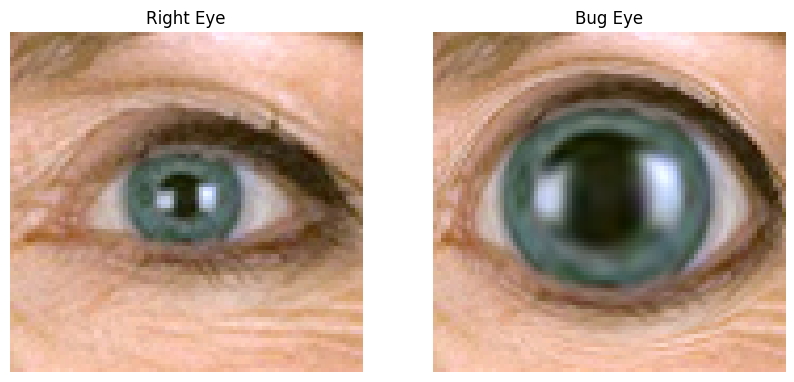

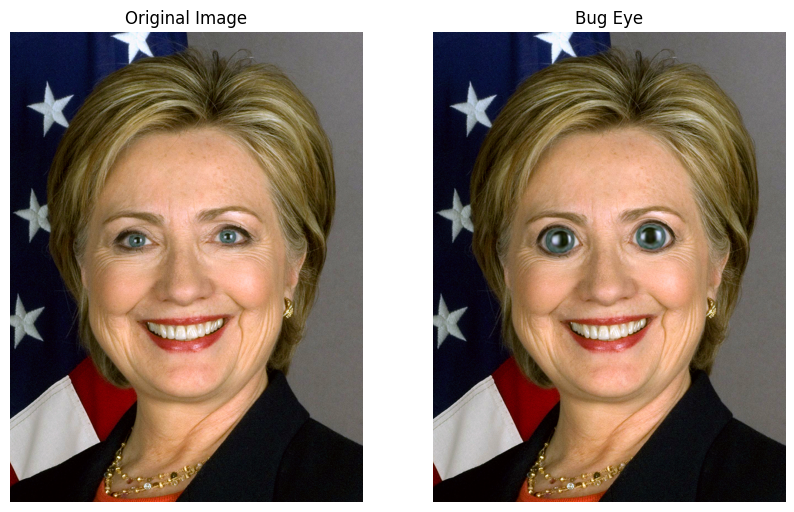

In [6]:
# Control the amount of deformation. 
bulgeAmount = 0.75

# Read image
input_file = DATA_PATH + "images/hillary-clinton.jpg"
src = cv2.imread(input_file)
height, width = src.shape[:2]

# Find the landmark points using DLIB Facial landmarks detector
landmarks = getLandmarks(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))

# Find the roi for left Eye
roiEyeLeft = [ landmarks[37][0] - radius, landmarks[37][1] - radius,
          (landmarks[40][0] - landmarks[37][0] + 2*radius),
          (landmarks[41][1] - landmarks[37][1] + 2*radius)  ]

# Find the roi for right Eye
roiEyeRight = [ landmarks[43][0] - radius, landmarks[43][1] - radius,
          (landmarks[46][0] - landmarks[43][0] + 2*radius),
          (landmarks[47][1] - landmarks[43][1] + 2*radius)  ]

output = np.copy(src)

# Find the patch for left eye and apply the transformation
leftEyeRegion = src[roiEyeLeft[1]:roiEyeLeft[1] + roiEyeLeft[3],roiEyeLeft[0]:roiEyeLeft[0] + roiEyeLeft[2]]
leftEyeRegionDistorted = barrel(leftEyeRegion, bulgeAmount);
output[roiEyeLeft[1]:roiEyeLeft[1] + roiEyeLeft[3],roiEyeLeft[0]:roiEyeLeft[0] + roiEyeLeft[2]] = leftEyeRegionDistorted

# Find the patch for right eye and apply the transformation
rightEyeRegion = src[roiEyeRight[1]:roiEyeRight[1] + roiEyeRight[3],roiEyeRight[0]:roiEyeRight[0] + roiEyeRight[2]]
rightEyeRegionDistorted = barrel(rightEyeRegion, bulgeAmount);
output[roiEyeRight[1]:roiEyeRight[1] + roiEyeRight[3],roiEyeRight[0]:roiEyeRight[0] + roiEyeRight[2]] = rightEyeRegionDistorted

plt.figure(figsize=[10,10])
plt.subplot(121);plt.imshow(rightEyeRegion[...,::-1]);plt.title("Right Eye")
plt.axis('off')


plt.subplot(122);plt.imshow(rightEyeRegionDistorted[...,::-1]);plt.title("Bug Eye")
plt.axis('off')

plt.figure(figsize=[10,10])
plt.subplot(121);plt.imshow(src[...,::-1]);plt.title("Original Image")
plt.axis('off')
plt.subplot(122);plt.imshow(output[...,::-1]);plt.title("Bug Eye")
plt.axis('off')

cv2.imwrite('output.jpg', output)